# Анализ оттока клиентов

Презентация: https://disk.yandex.ru/i/0m7bq9q_oEg7tA

# Шаг 1. Загрузим данные

Импортируем библиотеки и прочитаем файл

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np 
from scipy import stats as st 
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('/datasets/bank_dataset.csv')# чтение файла с данными и сохранение в df
df.head()

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


Посмотрим на информацию датасета, переведем категориальные данные в количественные

In [3]:
df.to_csv('file.csv')

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [113]:
df = df.drop('userid', axis = 1)
df = df.replace({'Gender': {'М': 1, 'Ж': 0}})
df = df.replace({'City': {'Ростов Великий': 0, 'Рыбинск': 1, 'Ярославль': 2}})

Найдем количесвто дубликатов

In [114]:
df.duplicated().sum() 

0

Узнаем долю пропусков в датасете

In [115]:
round((df.isna().mean()*100),2)

score                0.00
City                 0.00
Gender               0.00
Age                  0.00
Objects              0.00
Balance             36.17
Products             0.00
CreditCard           0.00
Loyalty              0.00
estimated_salary     0.00
Churn                0.00
dtype: float64

Посмотрим на пропущенные значения в столбце 'Balance', возможно у этих пользователей есть что то общее

In [116]:
df_na = df.fillna(1)
df_null = df_na.query('Balance==1')
df_no_null = df_na.query('Balance!=1')


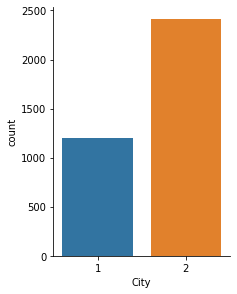

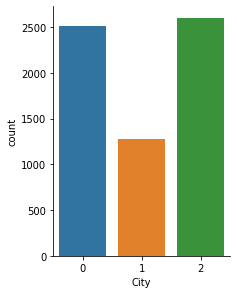

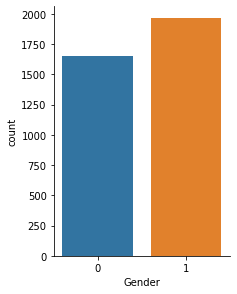

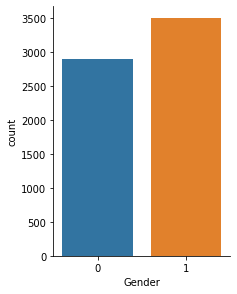

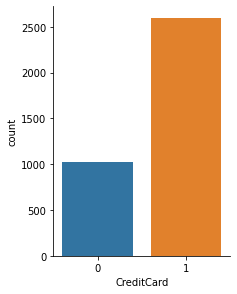

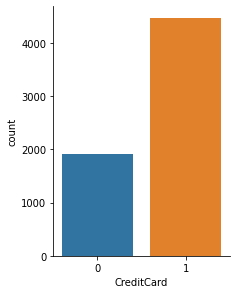

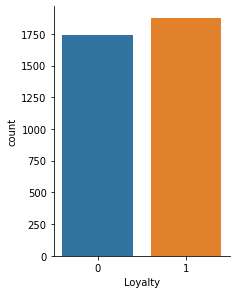

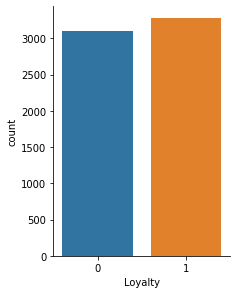

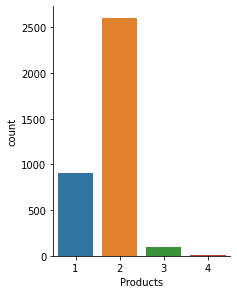

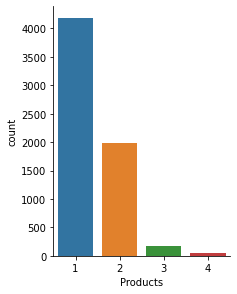

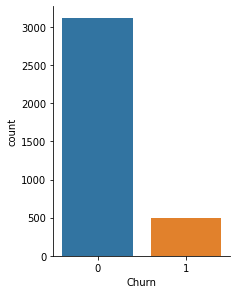

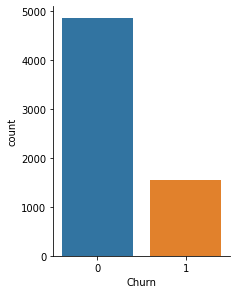

In [117]:
df_null = df_null[['City','Gender','CreditCard', 'Loyalty','Products','Churn']]
df_no_null = df_no_null[['City','Gender','CreditCard', 'Loyalty','Products','Churn']]
for col in df_null.columns:
    sns.catplot(col, data = df_null, kind="count", height=4, aspect=.8)
    sns.catplot(col, data = df_no_null, kind="count", height=4, aspect=.8)

В пропущенных значениях нет города Ростов Великий, а так же подозрительно много значений продуктов (два). Это количество совпадает с количесвтом кредитных карт, что логично. Но наличие кредитной карты никак не влияет на природу этих пропусков.

In [118]:
# функция, которая вычисляет метрики
def print_all_metrics(y_true, y_pred, y_proba, title = 'Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

In [119]:
X = df_no_null.drop('Churn', axis = 1)
y = df_no_null['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
rf_model = RandomForestClassifier(n_estimators = 100)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:,1]
print_all_metrics(y_test, rf_predictions, rf_probabilities, title = 'Метрики для данных без пропусков:')

Метрики для данных без пропусков:
	Accuracy: 0.79
	Precision: 0.69
	Recall: 0.26
	F1: 0.38
	ROC_AUC: 0.74


Качество модели, если не учитывать пропуски 0,74. Посмотрим, что будет если их заполнить

Для обработки пропусков можно взять столбец "Заработная плата" и умножить на  медианное отношение баланса на счете к "ЗП"

In [120]:
k = (df['Balance']/df['estimated_salary']).median()
df['Balance'] = df['Balance'].fillna(df['estimated_salary']*k)

Посмотрим на датасет: есть ли в нем отсутствующие признаки, изучим средние значения и стандартные отклонения

In [121]:
df.describe()

,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,1.250500,0.545700,38.921800,5.012800,119145.414696,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,0.830433,0.497932,10.487806,2.892174,47854.854018,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,0.000000,0.000000,18.000000,0.000000,107.320974,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,0.000000,0.000000,32.000000,3.000000,92360.065000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,2.000000,1.000000,37.000000,5.000000,119511.405985,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,2.000000,1.000000,44.000000,7.000000,146769.400000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,2.000000,1.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Посмотрим на средние значения признаков в двух группах

In [122]:
df.groupby('Churn').agg('mean')

,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary
Churn,,,,,,,,,,
0,651.853196,1.315082,0.572523,37.408389,5.033279,118702.489144,1.544267,0.707146,0.554565,99738.391772
1,645.351497,0.998036,0.440844,44.837997,4.932744,120876.890481,1.475209,0.699067,0.360825,101465.677531


Уже по средним значениям можно сделать следующие выводы:
- значения городов в оттоке разные
- разный средний возраст

Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

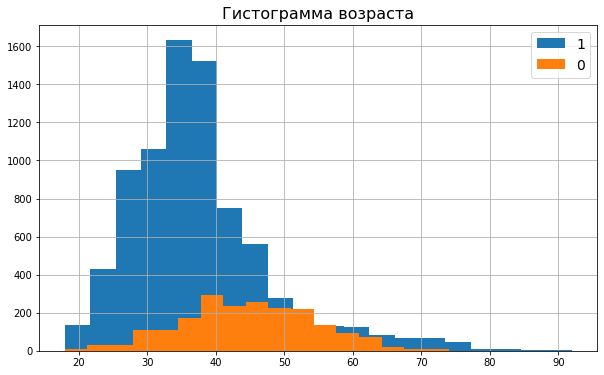

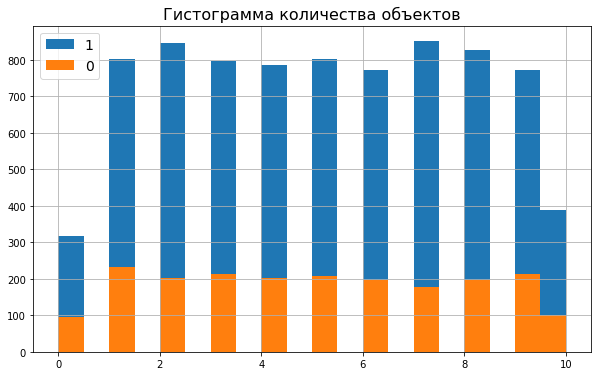

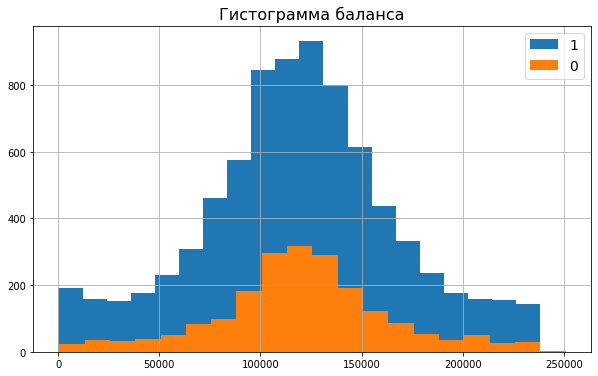

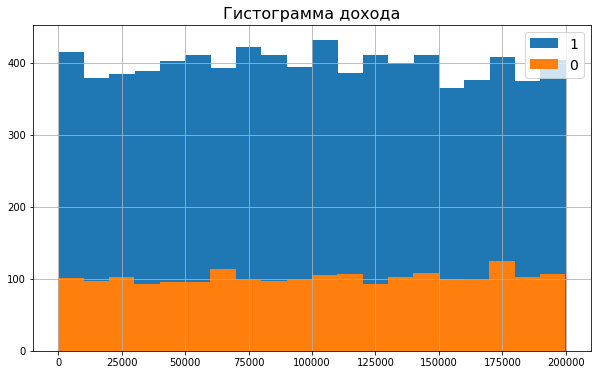

In [123]:
df_churn=df.query('Churn == 1')
df_no_churn=df.query('Churn == 0')
columns_hist=['Age','Objects','Balance','estimated_salary']
columns_name=['Гистограмма возраста','Гистограмма количества объектов','Гистограмма баланса','Гистограмма дохода']
for x,y in zip(columns_hist,columns_name):    
    plt.figure(figsize=(10,6))
    df_no_churn[x].hist(bins=20)
    df_churn[x].hist(bins=20)   
    plt.title(y, fontsize=16)
    plt.legend(['1', '0'], fontsize=14)
    plt.show()

Из этих гистограмм можем сделать следующие выводы:
- Клиенты которые в оттоке, более старшие
- Количесвто объектов распределяется примерно равномерно
- Гистограмма баланса рисует нормальное распределение
- Гистограмма дохода странно распределена,   должно  быть нормальное распределение

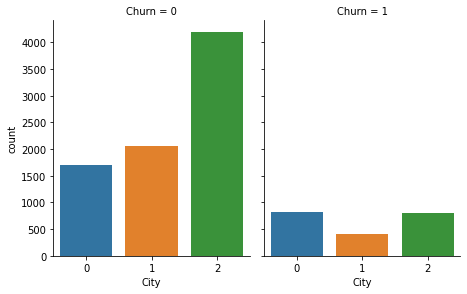

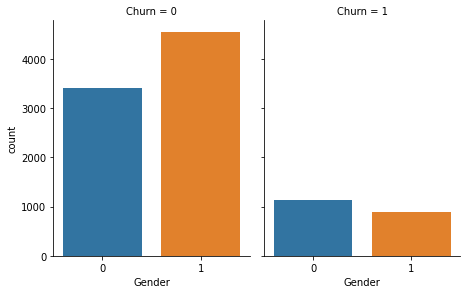

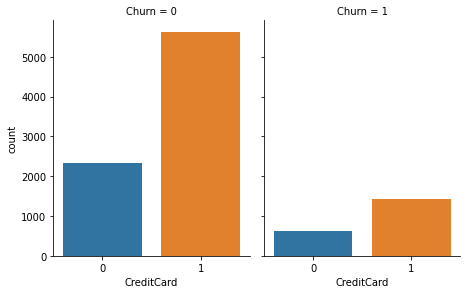

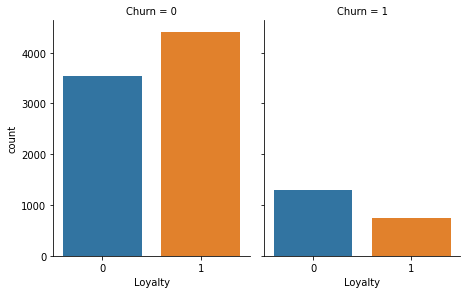

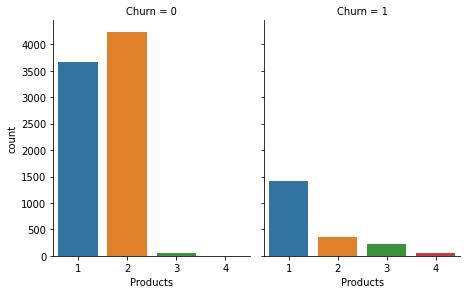

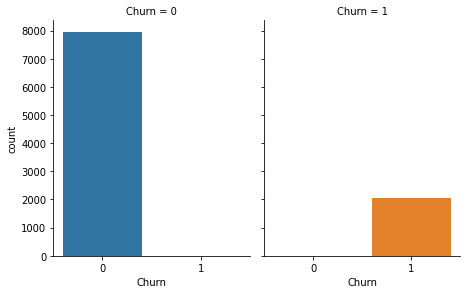

In [124]:
binar_feat = df[['City','Gender','CreditCard', 'Loyalty','Products','Churn']]
for col in binar_feat.columns:
    sns.catplot(col, col="Churn", data = binar_feat, kind="count", height=4, aspect=.8)

Из этих диаграмм видим следующее:
- Из Ростова Великого уходят чаще чем из других город
- Женщин в отток попадает больше
- Наличие кредитки не влияет на отток
- Лояльность у пользователей, которые ушли меньше, что логично
- Распределение продуктов интересное, есть клиенты у которых 3 или 4 продукта (в основном 1) и они попали в отток, в то время как у "лояльных" клиентов в основном 2 продукта
- 20% оттока 


Построим матрицу корреляций

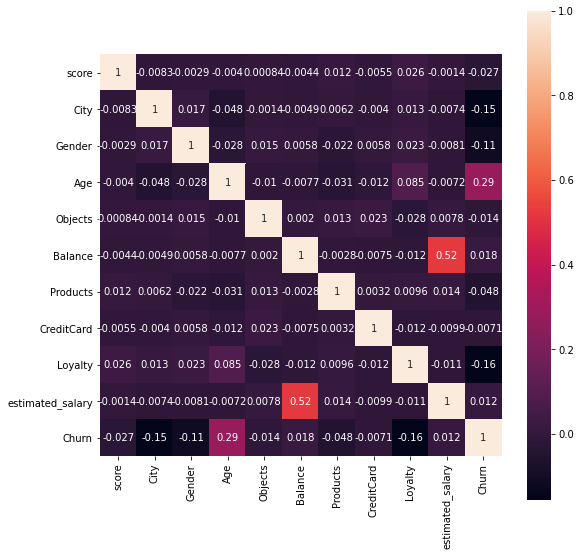

In [125]:
plt.figure(figsize=(9, 9))
sns.heatmap(df.corr(), annot=True, square=True)
plt.show()

Сильно коррелирует возраст с оттоком, а так же месячная заплата с балансом счета.

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце. Интресно какие метрики будут по модели случайного леса

In [126]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('Churn', axis = 1)
y = df['Churn']
# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [127]:
# Применяем модель случайного леса
rf_model = RandomForestClassifier(n_estimators = 100)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:,1]
print_all_metrics(y_test, rf_predictions, rf_probabilities, title = 'Метрики для модели случайного леса:')

Метрики для модели случайного леса:
	Accuracy: 0.86
	Precision: 0.78
	Recall: 0.47
	F1: 0.58
	ROC_AUC: 0.86


Качество модели случайного леса хорошее 0.86 по ROC_AUC, а с удалением пропусков 0,74, что заметно хуже. Решение заполнения пропусков было верным.

In [128]:
f_m = pd.DataFrame({'feature' : X_train.columns, 'importance' : rf_model.feature_importances_})
f_m.sort_values(by='importance', ascending=False)

,feature,importance
3,Age,0.234360
5,Balance,0.161467
9,estimated_salary,0.144447
0,score,0.140041
6,Products,0.122802
4,Objects,0.076956
8,Loyalty,0.044760
1,City,0.039255
7,CreditCard,0.018445
2,Gender,0.017468


По модели самым важным признаком является возраст (0.24), по корреляции с оттоком это самый сильный показатель. 

# Шаг 4. Сделаем кластеризацию клиентов

In [129]:
# стандартизируем данные
sc = StandardScaler()
x_sc = sc.fit_transform(X)
#linked = linkage(x_sc, method = 'ward')
#plt.figure(figsize=(15, 10))  
#dendrogram(linked, orientation='top')
#plt.title('Иерархическая кластеризация')
#plt.show()
# специально закоментил, долго ждать загрузки

In [130]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters = 5, random_state=0)
labels = km.fit_predict(x_sc)
df_clust_1 = df
df_clust_1['cluster_km'] = labels

In [131]:
# выводим статистику по средним значениям наших признаков по кластеру
df_clust_final = df_clust_1.copy(deep=True)
df_clust_grouped_mean = df_clust_final.groupby('cluster_km').agg('mean')
df_clust_grouped_mean

,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
cluster_km,,,,,,,,,,,
0,646.929187,0.248752,0.527916,37.326827,5.124376,119832.472648,1.495688,1.000000,0.453473,101177.573554,0.276441
1,651.334073,1.787045,0.564774,35.807897,5.066548,158782.805893,1.566548,0.980479,0.464064,146788.122742,0.145075
2,650.333333,1.752475,0.560585,35.878359,5.018859,69928.813235,1.592645,0.904290,0.506365,43496.821693,0.133428
3,652.825081,1.196429,0.542208,37.282873,4.911120,125780.453947,1.501218,0.000000,0.494724,106789.429067,0.210227
4,651.438413,1.319415,0.517745,60.869520,4.877871,116205.338037,1.460334,0.755741,0.848643,95784.826284,0.313152


In [132]:
#Построим распределения признаков для кластеров
binary_no = df.drop(columns =(['City','Gender', 'Objects', 'Products','CreditCard', 'Loyalty','Churn','cluster_km']))
binary = df[['City','Gender', 'Objects', 'Products','CreditCard', 'Loyalty']]

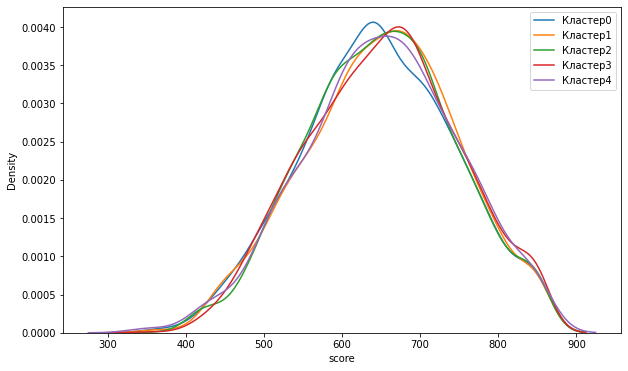

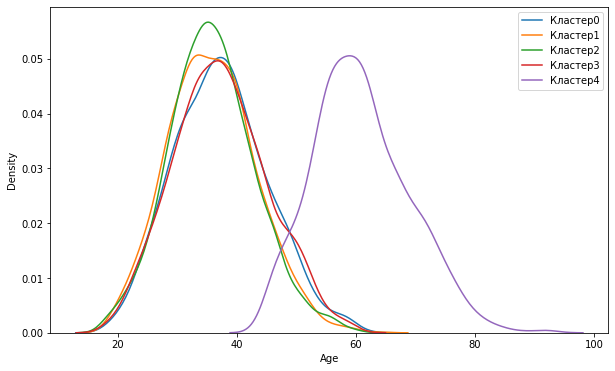

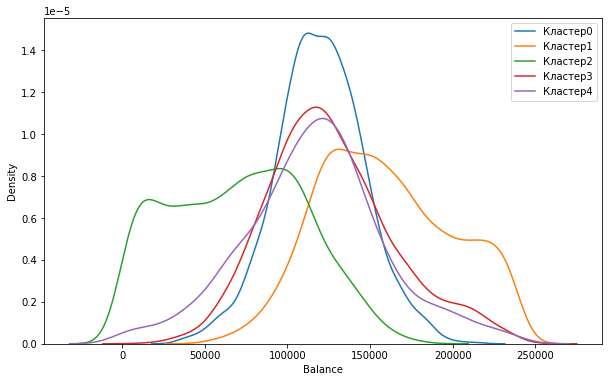

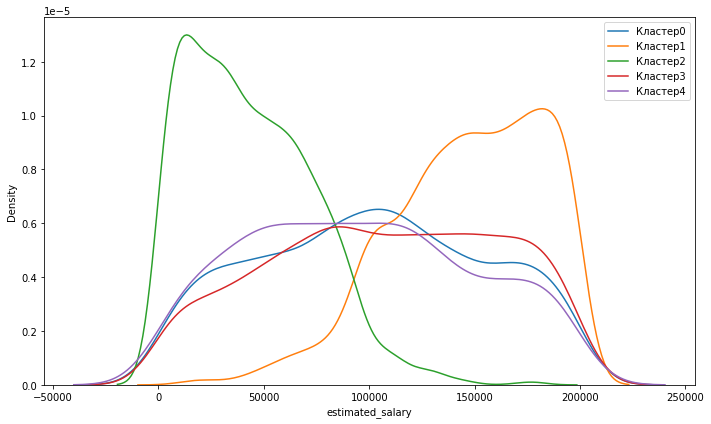

In [133]:
for col in binary_no:
    plt.figure(figsize=(10, 6))
    for i in range(0,5):
        sns.distplot(df_clust_1.query('cluster_km == @i')[col],
                    hist=False,
                    #legend=True,
                    kde_kws={'label':'Кластер'+ str(i)}) 
        plt.legend()        
plt.tight_layout()

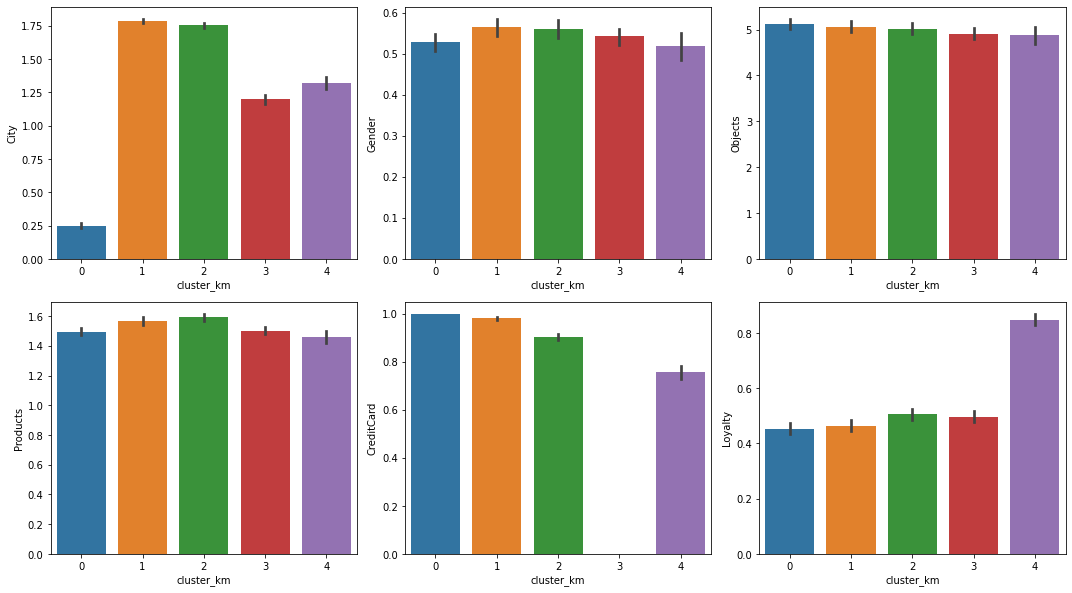

In [134]:
plt.figure(figsize=(15,12))
for i in range(len(binary.columns)):
    plt.subplot(3,3,i+1)
    x = df_clust_1['cluster_km']
    y = binary.iloc[:,i]
    sns.barplot(x=x, y=y)
plt.tight_layout()
plt.show()

Промежуточные результаты:  
- повышенный отток наблюдается у 0 и 4-ого кластера
- у нулевого кластера пользователи преимущественно из Ростова Великого с кредитными картами
- у четвертого кластера пользователи преимущественно пожилые люди, с высоким  уровнем лояльности, но при этом самым высоким оттоком
- у второго кластера сымый маленький отток, при этом самый низский доход и баланс на счете
- у третьего кластера средний отток, при этом нет кредитной  карты

# Шаг 4. Проверим гипотезы

## Средний доход между теми клиентами, которые ушли и теми, которые остались одинаковый

Нулевая гипотеза: средний доход между теми клиентами, которые ушли и теми, которые остались одинаковый. Альтернативная гипотеза: средний доход между теми клиентами, которые ушли и теми, которые остались не одинаковый. Используем для двух генеральных совокупностей st.ttest_ind

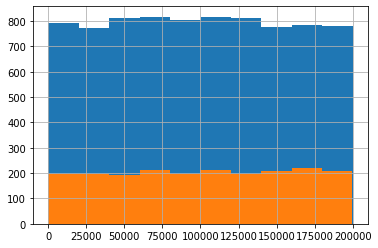

In [135]:
df_churn = df.query('Churn == 1')
df_no_churn = df.query('Churn == 0')
df_no_churn['estimated_salary'].hist()
df_churn['estimated_salary'].hist()
plt.show()

Данные не распределены нормально, поэтому применяем тест Манна Уитни

In [136]:
 alpha = 0.05 # задаем критический уровень статистической значимости

result_fist = st.mannwhitneyu(df_no_churn['estimated_salary'], df_churn['estimated_salary'])

print('p-значение:', result_fist.pvalue) # выведите на экран полученное p-значение)

if result_fist.pvalue < alpha:# сравните p-значение с заданным критическим уровнем стат. значимости:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.22705150930153783
Не получилось отвергнуть нулевую гипотезу


Средний доход ушедших и оставшихся с банком примерно одинаковый. Нулевую гипотезу не отвергаем

## Средний возраст между теми клиентами, которые ушли и теми, которые остались одинаковый

Нулевая гипотеза: средний возраст между теми клиентами, которые ушли и теми, которые остались одинаковый. Альтернативная гипотеза: средний возраст между теми клиентами, которые ушли и теми, которые остались не одинаковый. Используем для двух генеральных совокупностей st.ttest_ind

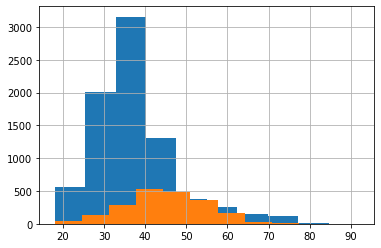

In [137]:
df_no_churn['Age'].hist()
df_churn['Age'].hist()
plt.show()

Проверяем нанормальность распределения методом Шапиро-Уилка

In [138]:
shapiro1 = st.shapiro(df_churn['Age'])
shapiro1

ShapiroResult(statistic=0.9977729916572571, pvalue=0.005956501234322786)

In [139]:
shapiro2 = st.shapiro(df_no_churn['Age'])
shapiro2

/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9062122106552124, pvalue=0.0)

Гистограмма с оттоковыми пользователями распределена хуже чем у клиентов банка, поэтому так же применяем тест Манна Уитни

In [140]:
 
alpha = 0.05 # задаем критический уровень статистической значимости

result_fist = st.mannwhitneyu(df_no_churn['Age'], df_churn['Age'])

print('p-значение:', result_fist.pvalue) # выведите на экран полученное p-значение)

if result_fist.pvalue < alpha:# сравните p-значение с заданным критическим уровнем стат. значимости:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.2104014319371675e-230
Отвергаем нулевую гипотезу


А вот средний возраст пользователей оттока не совпадает с возрастом оставшихся, что в лишний раз подтверждает наши результаты.

#  Шаг 5. Сформулируем выводы и сделаем базовые рекомендации по работе с клиентами

Стоит обратить большее внимание на более взрослую аудиторию, людей старше 60 лет, в частности женского пола, так как этот признак самый влиятельный на отток. Возможно им стоит предложить более лучшие условия тарифа, скидки. Например можно предложить им бесплатное обслуживание дебетовой карты или более лучшие условия кредитки. Так же большой отток показывают клиенты из Ростова Великого с кредитными картами, возможно они столкнулись с какой то технической ошибкой. Нужно проверить обращения в тех поддержку из этого города. Еще большой отток у клиентов, которые имеют один продукт и это кредитная карта. Таким клиентам стоит предложить дебетовую карту или более лучшие условия тарифа кредитной карты. Самый маленький отток у клиентов с низким доходом и балансом на счете, от таких клиентов банк получает мало прибыли. Банку нужно поменять вектор развития стратегии на более состоятельную аудиторию, повысить их лояльность.   